In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
train_df = pd.read_csv("train.csv")

# Columns
cat_cols = ["neighbourhood_group", "room_type"]
num_cols = ["minimum_nights", "amenity_score", "number_of_reviews", "availability_365"]

# Fill missing values
for c in cat_cols:
    train_df[c] = train_df[c].fillna(train_df[c].mode()[0])
for c in num_cols:
    train_df[c] = train_df[c].fillna(train_df[c].median())

# One-hot encode
train_encoded = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

# Convert bool → int
bool_cols = train_encoded.select_dtypes(include=["bool"]).columns
train_encoded[bool_cols] = train_encoded[bool_cols].astype(int)

# Split features and target
X = train_encoded.drop("price_class", axis=1).values
y = train_encoded["price_class"].values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize numeric columns (fit on train only)
scaler = StandardScaler()
X_train[:, :4] = scaler.fit_transform(X_train[:, :4])
X_val[:, :4] = scaler.transform(X_val[:, :4])

print("Shapes:", X_train.shape, X_val.shape)
print("NaNs:", np.isnan(X_train).sum())


Shapes: (33078, 10) (8270, 10)
NaNs: 0


In [4]:
Xtr, Xva = X_train, X_val
ytr, yva = y_train, y_val


In [5]:
print(np.unique(y_train))


[0 1 2 3]


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def one_hot(y, num_classes):
    Y = np.zeros((y.size, num_classes))
    Y[np.arange(y.size), y] = 1
    return Y

def softmax(logits):
    # stable softmax
    z = logits - np.max(logits, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(a):
    # derivative wrt pre-activation using activated value a = sigmoid(z)
    return a * (1 - a)

def relu(x):
    return np.maximum(0, x)

def drelu(z):
    return (z > 0).astype(float)

# ---------- model ----------
class MLP2Hidden:
    def __init__(self, input_dim, h1, h2, num_classes, activation="relu", seed=42):
        rng = np.random.default_rng(seed)
        self.activation = activation

        # He init for ReLU, Xavier for Sigmoid
        if activation == "relu":
            self.W1 = rng.normal(0, np.sqrt(2/input_dim), (input_dim, h1))
            self.W2 = rng.normal(0, np.sqrt(2/h1), (h1, h2))
        else:
            self.W1 = rng.normal(0, np.sqrt(1/input_dim), (input_dim, h1))
            self.W2 = rng.normal(0, np.sqrt(1/h1), (h1, h2))

        self.W3 = rng.normal(0, np.sqrt(1/h2), (h2, num_classes))
        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, num_classes))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        if self.activation == "relu":
            a1 = relu(z1)
        else:
            a1 = sigmoid(z1)

        z2 = a1 @ self.W2 + self.b2
        if self.activation == "relu":
            a2 = relu(z2)
        else:
            a2 = sigmoid(z2)

        logits = a2 @ self.W3 + self.b3
        probs = softmax(logits)

        cache = (X, z1, a1, z2, a2, logits, probs)
        return probs, cache

    def loss(self, probs, y):
        # cross-entropy (no autograd)
        n = y.shape[0]
        # small epsilon for safety
        eps = 1e-12
        return -np.mean(np.log(probs[np.arange(n), y] + eps))

    def backward(self, cache, y):
        X, z1, a1, z2, a2, logits, probs = cache
        n = X.shape[0]

        # dL/dlogits for softmax + cross entropy
        dlogits = probs.copy()
        dlogits[np.arange(n), y] -= 1
        dlogits /= n

        # Gradients for W3, b3
        dW3 = a2.T @ dlogits
        db3 = np.sum(dlogits, axis=0, keepdims=True)

        # Backprop into layer 2
        da2 = dlogits @ self.W3.T
        if self.activation == "relu":
            dz2 = da2 * drelu(z2)
        else:
            dz2 = da2 * dsigmoid(a2)

        dW2 = a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        # Backprop into layer 1
        da1 = dz2 @ self.W2.T
        if self.activation == "relu":
            dz1 = da1 * drelu(z1)
        else:
            dz1 = da1 * dsigmoid(a1)

        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
        return grads

    def step(self, grads, lr=0.1):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]
        self.W3 -= lr * grads["dW3"]
        self.b3 -= lr * grads["db3"]

def train_model(X_train, y_train, X_val, y_val, activation="relu",
                h1=32, h2=16, lr=0.1, iters=200, seed=42):
    n_features = X_train.shape[1]
    n_classes = len(np.unique(y_train))

    model = MLP2Hidden(n_features, h1, h2, n_classes, activation=activation, seed=seed)

    train_acc_hist, val_acc_hist = [], []
    train_loss_hist = []
    gradW1_hist, gradW2_hist = [], []

    for t in range(iters):
        probs, cache = model.forward(X_train)
        loss = model.loss(probs, y_train)
        grads = model.backward(cache, y_train)
        model.step(grads, lr=lr)

        # accuracy
        train_pred = np.argmax(probs, axis=1)
        train_acc = accuracy(y_train, train_pred)

        val_probs, _ = model.forward(X_val)
        val_pred = np.argmax(val_probs, axis=1)
        val_acc = accuracy(y_val, val_pred)

        # gradient magnitudes (average abs)
        gradW1_hist.append(np.mean(np.abs(grads["dW1"])))
        gradW2_hist.append(np.mean(np.abs(grads["dW2"])))

        train_loss_hist.append(loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        if (t+1) % 50 == 0:
            print(f"[{activation}] iter {t+1:3d} | loss={loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    history = {
        "train_acc": np.array(train_acc_hist),
        "val_acc": np.array(val_acc_hist),
        "train_loss": np.array(train_loss_hist),
        "gradW1": np.array(gradW1_hist),
        "gradW2": np.array(gradW2_hist),
    }
    return model, history


In [7]:
# IMPORTANT: X_train etc should be numpy arrays. If they're DataFrames, do .values
Xtr, Xva = X_train, X_val
ytr, yva = y_train, y_val

relu_model, relu_hist = train_model(Xtr, ytr, Xva, yva, activation="relu", h1=32, h2=16, lr=0.1, iters=200)
sig_model,  sig_hist  = train_model(Xtr, ytr, Xva, yva, activation="sigmoid", h1=32, h2=16, lr=0.1, iters=200)


[relu] iter  50 | loss=0.7066 | train_acc=0.7173 | val_acc=0.7180
[relu] iter 100 | loss=0.5110 | train_acc=0.7984 | val_acc=0.7964
[relu] iter 150 | loss=0.4456 | train_acc=0.8182 | val_acc=0.8155
[relu] iter 200 | loss=0.4171 | train_acc=0.8261 | val_acc=0.8219
[sigmoid] iter  50 | loss=1.1043 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 100 | loss=1.0909 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 150 | loss=1.0734 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 200 | loss=1.0483 | train_acc=0.5632 | val_acc=0.5632


To increase sigmoid accuracy : reducing learning rate + using Xavier init (already) + trying lr=0.01:

In [8]:
sig_model2, sig_hist2 = train_model(X_train, y_train, X_val, y_val,
                                   activation="sigmoid", h1=32, h2=16, lr=0.01, iters=200)


[sigmoid] iter  50 | loss=1.1405 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 100 | loss=1.1215 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 150 | loss=1.1158 | train_acc=0.5632 | val_acc=0.5632
[sigmoid] iter 200 | loss=1.1130 | train_acc=0.5632 | val_acc=0.5632


In [9]:
print("ReLU gradW1 last:", relu_hist["gradW1"][-1], "gradW2 last:", relu_hist["gradW2"][-1])
print("Sig  gradW1 last:", sig_hist["gradW1"][-1],  "gradW2 last:", sig_hist["gradW2"][-1])


ReLU gradW1 last: 0.00110947133580804 gradW2 last: 0.0008317163662931068
Sig  gradW1 last: 0.0010499931293433263 gradW2 last: 0.001344705890426397


In [10]:
print("Final ReLU train accuracy:", relu_hist["train_acc"][-1])
print("Final ReLU val accuracy:", relu_hist["val_acc"][-1])

print("Final Sigmoid train accuracy:", sig_hist["train_acc"][-1])
print("Final Sigmoid val accuracy:", sig_hist["val_acc"][-1])


Final ReLU train accuracy: 0.8261382187556684
Final ReLU val accuracy: 0.8218863361547764
Final Sigmoid train accuracy: 0.563183989358486
Final Sigmoid val accuracy: 0.5632406287787183


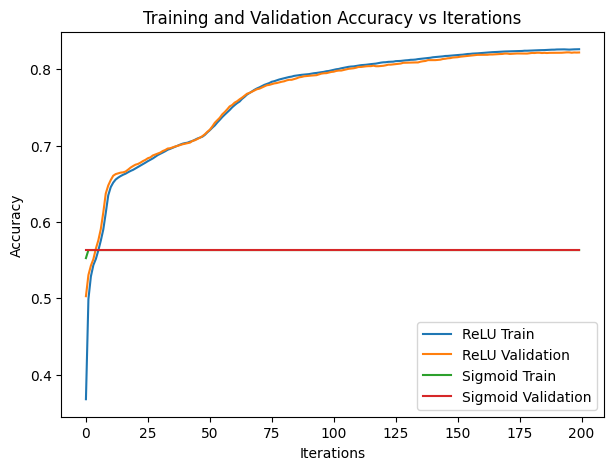

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.plot(relu_hist["train_acc"], label="ReLU Train")
plt.plot(relu_hist["val_acc"], label="ReLU Validation")

plt.plot(sig_hist["train_acc"], label="Sigmoid Train")
plt.plot(sig_hist["val_acc"], label="Sigmoid Validation")

plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Iterations")
plt.legend()
plt.show()


Figure X shows the variation of training and validation accuracy over 200 iterations for both activation functions. The ReLU-activated network demonstrates steady improvement in both training and validation accuracy, converging to approximately 0.826 training accuracy and 0.822 validation accuracy. The close proximity of the two curves indicates that the model generalizes well without significant overfitting.

In contrast, the sigmoid-activated network shows minimal improvement in accuracy, remaining near 0.563 throughout training. This behavior suggests that the network failed to effectively optimize the loss function, likely due to vanishing gradient effects associated with sigmoid activations.

Overall, the results demonstrate that ReLU provides more stable gradient propagation and faster convergence compared to sigmoid in multi-layer neural networks.